In [1]:
from IPython.core.display import HTML
HTML("<style>.container { width:98% !important; }</style>")

In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload

import lnPi
reload(lnPi)

<module 'lnPi' from '/home/local/NIST/dsideriu/Tutorials/lnPi/lnPi/__init__.py'>

In [4]:
lnpi_ref = lnPi.lnPi_phases.from_file('./nahs_mix.11_11_03.lnpi_o.dat',mu=[0.5,0.5],fill_value=np.nan,ZeroMax=True,num_phases_max=2,beta=1.0,
                                     build_kwargs=dict(num_phases_max=5),
                                      ftag_phases=lnPi.tag_phases_binary) 

In [5]:
def get_spin_bin(ref,mu_in,x,spin_kwargs=None,bin_kwargs=None):
    
    if spin_kwargs is None: spin_kwargs={}
    if bin_kwargs is None: bin_kwargs = {}
    
    #initial estimate
    C = lnPi.lnPi_collection.from_mu(ref,mu_in,x)
    
    C.get_spinodals(**spin_kwargs)
    C.get_binodals(**bin_kwargs)
    
    return C
            

In [6]:
import tqdm

In [7]:
L=[]
for mu2 in tqdm.tqdm(np.arange(-4,4,0.2),leave=True):
    try:
        C = get_spin_bin(lnpi_ref,[None,mu2],np.linspace(-10.,10.,2),spin_kwargs=dict(nmax=40,ntry=40))
    except:
        print('error at mu2',mu2)
        break
    L.append(C)

  5%|▌         | 2/40 [00:00<00:16,  2.33it/s]/home/local/NIST/dsideriu/Tutorials/lnPi/lnPi/__init__.py:1506: RuntimeWarning: All-NaN slice encountered
  new_row = np.nanmin(Etrans[[idx_kill, idx_keep], :], axis=0)
 88%|████████▊ | 35/40 [00:25<00:03,  1.28it/s]/home/local/NIST/dsideriu/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1019: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
100%|██████████| 40/40 [00:29<00:00,  1.43it/s]


In [8]:
LL = L

# write to h5

In [9]:
import h5py
fname = 'conf_sym.h5'
!rm $fname
F = h5py.File(fname)

lnpi_ref.to_hdf(F,'lnpi_ref',overwrite=True)
collection_list = []
for i,x in enumerate(LL):
    key = 'collection_%i'%i
    collection_list.append(key)
    x.to_hdf(F,'collection_%i'%i,ref=None,overwrite=True)

F.create_dataset('collection_list',data=np.array(collection_list,dtype='S'))

F.close()

In [10]:
!ls -lh $fname

-rw-r--r-- 1 dsideriu domain^users 15M Apr 11 11:58 conf_sym.h5


# read h5

In [11]:
#load file to lst
fname = 'conf_sym.h5'
with h5py.File(fname,'r') as f:
    ref = lnPi.lnPi_phases.from_hdf(f,'lnpi_ref')
    lst = []
    for k in f['collection_list']:
        lst.append(lnPi.lnPi_collection.from_hdf(f,k,ref=ref))

    f.close()

In [12]:
l = []
for x in lst:
    
    d = {}

    spin = x.spinodals
    if spin[0] is None:
        #no spin
        pass 
    else:
        #spin
        for i,pp in enumerate(spin):
            p = pp.merge_phases(efac=0.8)
            for j in range(2):
                d['mu_spin_%i_comp_%i'%(i,j)] = p.mu[j]
                
            d['omega_spin_%i'%(i)] = p.Omegas_phaseIDs()[i]
                
            d['molfrac_spin_%i_comp_0'%i] = p.molfracs_phaseIDs[i,0]
            
        
    bino = x.binodals[0]
    if bino is None:
        pass
    else:
        #no bin
        p = bino.merge_phases(efac=0.8)

        for i in range(2):
            for j in range(2):
                d['mu_bin_%i_comp_%i'%(i,j)] = p.mu[j]

            d['omega_bin_%i'%(i)] = p.Omegas_phaseIDs()[i]
            d['molfrac_bin_%i_comp_0'%i] = p.molfracs_phaseIDs[i,0]
    l.append(d)
    
df = pd.DataFrame(l)

In [13]:
df.to_hdf('conf_sym.h5','df')

In [14]:
df = pd.read_hdf('conf_sym.h5','df')

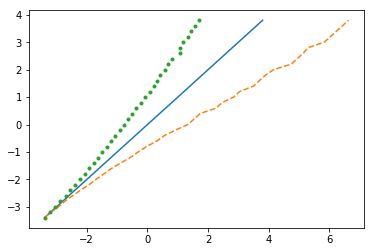

In [15]:
plt.plot(df.mu_bin_0_comp_0,df.mu_bin_0_comp_1)
plt.plot(df.mu_spin_0_comp_0,df.mu_spin_0_comp_1,'--')
plt.plot(df.mu_spin_1_comp_0,df.mu_spin_1_comp_1,'.')

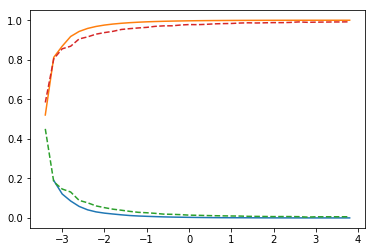

In [16]:
plt.plot(df.mu_bin_0_comp_1,df.molfrac_bin_0_comp_0)
plt.plot(df.mu_bin_1_comp_1,df.molfrac_bin_1_comp_0)

plt.plot(df.mu_spin_0_comp_1,df.molfrac_spin_0_comp_0,'--')
plt.plot(df.mu_spin_1_comp_1,df.molfrac_spin_1_comp_0,'--')

In [17]:
for k,d in dfL.iteritems():
    
    l,=plt.plot(d.mu_bin_0_comp_1,d.molfrac_bin_0_comp_0,label=k)
    c = l.get_color()
    plt.plot(d.mu_bin_1_comp_1,d.molfrac_bin_1_comp_0,color=c)

    plt.plot(d.mu_spin_0_comp_1,d.molfrac_spin_0_comp_0,'--',color=c)
    plt.plot(d.mu_spin_1_comp_1,d.molfrac_spin_1_comp_0,'--',color=c)

plt.gca().legend(loc=0)

NameError: name 'dfL' is not defined

In [ ]:
for k,d in dfL.iteritems():
    
    l,=plt.plot(d.mu_bin_0_comp_1,d.molfrac_bin_0_comp_0,label=k)
    c = l.get_color()
    plt.plot(d.mu_bin_1_comp_1,d.molfrac_bin_1_comp_0,color=c)

    plt.plot(d.mu_spin_0_comp_1,d.molfrac_spin_0_comp_0,'--',color=c)
    plt.plot(d.mu_spin_1_comp_1,d.molfrac_spin_1_comp_0,'--',color=c)

plt.gca().legend(loc=0)

In [ ]:
for k,d in dfL.iteritems():
    
    l,=plt.plot(d.mu_bin_0_comp_1,d.molfrac_bin_0_comp_0,label=k)
    c = l.get_color()
    plt.plot(d.mu_bin_1_comp_1,d.molfrac_bin_1_comp_0,color=c)

    plt.plot(d.mu_spin_0_comp_1,d.molfrac_spin_0_comp_0,'--',color=c)
    plt.plot(d.mu_spin_1_comp_1,d.molfrac_spin_1_comp_0,'--',color=c)

ax = plt.gca()

ax.legend(loc=0)
ax.set_ylim(-0.05,0.1)
ax.axhline(y=0.02)
ax.axhline(y=0.04)

In [ ]:
for k,d in dfL.iteritems():
    l,=plt.plot(d.mu_bin_0_comp_0,d.mu_bin_0_comp_1,label=k)
    plt.plot(d.mu_spin_0_comp_0,d.mu_spin_0_comp_1,'--',color=l.get_color())
    plt.plot(d.mu_spin_1_comp_0,d.mu_spin_1_comp_1,'.',color=l.get_color())
plt.gca().legend(loc=0)

In [ ]:
for k,d in dfL.iteritems() :
    
    l,=plt.plot(d.molfrac_bin_0_comp_0,-d.omega_bin_0,label=k)
    c=l.get_color()
    plt.plot(d.molfrac_bin_1_comp_0,-d.omega_bin_1,color=c) 
    
    plt.plot(d.molfrac_spin_0_comp_0,- d.omega_spin_0,color=c,ls='--')
    plt.plot(d.molfrac_spin_1_comp_0,- d.omega_spin_1,color=c,ls='--')
    
#     l,=plt.plot(d.mu_bin_0_comp_1,d.molfrac_bin_0_comp_0,label=k)
#     c = l.get_color()
#     plt.plot(d.mu_bin_1_comp_1,d.molfrac_bin_1_comp_0,color=c)

#     plt.plot(d.mu_spin_0_comp_1,d.molfrac_spin_0_comp_0,'--',color=c)
#     plt.plot(d.mu_spin_1_comp_1,d.molfrac_spin_1_comp_0,'--',color=c)

plt.gca().legend(loc=0)

In [ ]:
L[0]